In [35]:
import requests
import pandas as pd
import xml.etree.ElementTree as ET
import json
import html
import multiprocessing
from collections import Counter
from bs4 import BeautifulSoup
from pathlib import Path
from googleapiclient import discovery
import os, glob
import time
from googleapiclient.errors import HttpError
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np

In [2]:
with open('./apikey.txt') as api_file: 
    API_KEY = api_file.read()
    
API_CLIENT = api_client = discovery.build(
    "commentanalyzer",
    "v1alpha1",
    developerKey=API_KEY,
    discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
    static_discovery=False)

In [15]:
def query_perspective(text, languages = None):
    
    #post = json.load(content)
    
    analyze_request = {
        'comment': { 'text': text },
        'requestedAttributes': {'TOXICITY': {}, 'SEVERE_TOXICITY': {}, 'IDENTITY_ATTACK' : {}, 'INSULT': {}, 'PROFANITY' : {}, 'THREAT' : {}}
    }
    
    if(languages):
        analyze_request['languages'] = languages
    try :
        response = API_CLIENT.comments().analyze(body=analyze_request).execute()
    except (Exception,HttpError) as err:
        if (type(err) == HttpError):
            if (err.status_code == 429):
                time.sleep(61)
                return query_perspective(text=text, languages = languages)
            elif(err.status_code == 400):
                return None
        else :
            print("Catched an exception not dealt with.. we will print and then sleep and resume after 61 seconds. ")
            print("Exception : ")
            print(err)
            print("Skipping to next")
            return None
    return response['attributeScores']


In [4]:
from collections import Counter

A = [{'a':1,'b':2,'c':3,'d':4,'e':5},{'b':1,'c':2,'d':3,'e':4,'f':5},{'c':1,'d':2,'e':3,'f':4,'g':5}]

sums = Counter()
counters = Counter()
for itemset in A:
    sums.update(itemset)
    counters.update(itemset.keys())

ret = {x: float(sums[x])/counters[x] for x in sums.keys()}

print(ret)

{'a': 1.0, 'b': 1.5, 'c': 2.0, 'd': 3.0, 'e': 4.0, 'f': 4.5, 'g': 5.0}


In [5]:
with open('./scores.csv', 'w+') as scores_file :
    scores_file.write('twitter_username,mastodon_username,Twitter_TOXICITY,Twitter_SEVERE_TOXICITY,Twitter_IDENTITY_ATTACK,Twitter_INSULT,Twitter_PROFANITY,Twitter_THREAT,Mastodon_TOXICITY,Mastodon_SEVERE_TOXICITY,Mastodon_IDENTITY_ATTACK,Mastodon_INSULT,Mastodon_PROFANITY,Mastodon_THREAT')

In [18]:
def process_users_scores(twitter_username, mastodon_username):
    print(f"Processing {twitter_username}")
    # Example mastodon user : https://techhub.social/@nateplusplus
    # extract mastodon server name  
    mastodon_server = mastodon_username.split('https://')[1].split('/@')[0]
    # extract mastodon user name
    mastodon_user = mastodon_username.split('/@')[-1].split('/')[0]
    # build folder name as we constructed it before
    mastodon_folder = mastodon_server+'_'+mastodon_user
    
    ## TODO: for folder read all tweets and query api
    # 1. extract tweets
    try:
        tweets = glob.glob(f"./tweets/{twitter_username}/*.json")
        # 2. extract mastodon posts
        mastodon_posts = glob.glob(f"./mastodon_posts/{mastodon_folder}/*.json")
        if(len(mastodon_posts) == 0 ):
            print("Not processing this user as it has no mastodon posts")
            return
    except:
        print(f"This user is not present in one of the two socials, going next.")
        return
    tweets_amount = len(list(tweets))
    mastodon_posts_amount = len(list(mastodon_folder))
    
    twitter_scores = []
    mastodon_scores = []
    
    languages = set()
    print("scoring Mastodon")
    for post in tqdm(mastodon_posts) :
        with open(post, 'r+') as post_file:
            post_json = json.load(post_file)
        text = post_json['content']
        languages.add(post_json['language'])
        
        scores = query_perspective(text=text, languages = list(languages))
        if(not scores):
            continue

        mastodon_scores.append({
            'TOXICITY': scores['TOXICITY']['summaryScore']['value'],
                'SEVERE_TOXICITY': scores['SEVERE_TOXICITY']['summaryScore']['value'],
                'IDENTITY_ATTACK' : scores[ 'IDENTITY_ATTACK' ]['summaryScore']['value'],
                'INSULT': scores['INSULT']['summaryScore']['value'],
                'PROFANITY' : scores[ 'PROFANITY' ]['summaryScore']['value'],
                'THREAT' : scores[ 'THREAT' ]['summaryScore']['value']
        })
          
    print("scoring Twitter")  
    for tweet in tqdm(tweets) :
        with open(tweet, 'r+') as tweet_file:
            tweet_json = json.load(tweet_file)
        text = tweet_json['text']

        scores = query_perspective(text=text, languages= list(languages))
        if(not scores):
            continue

        twitter_scores.append(
            {
            'TOXICITY': scores['TOXICITY']['summaryScore']['value'],
            'SEVERE_TOXICITY': scores['SEVERE_TOXICITY']['summaryScore']['value'],
            'IDENTITY_ATTACK' : scores['IDENTITY_ATTACK']['summaryScore']['value'],
            'INSULT': scores['INSULT']['summaryScore']['value'],
            'PROFANITY' : scores['PROFANITY']['summaryScore']['value'],
            'THREAT' : scores['THREAT']['summaryScore']['value']
        })
        
    
    sums = Counter()
    counters = Counter()
    for itemset in mastodon_scores:
        sums.update(itemset)
        counters.update(itemset.keys())

    mastodon_score = {x: float(sums[x])/counters[x] for x in sums.keys()}

    sums = Counter()
    counters = Counter()
    for itemset in twitter_scores:
        sums.update(itemset)
        counters.update(itemset.keys())

    twitter_score = {x: float(sums[x])/counters[x] for x in sums.keys()}
    if(not (twitter_score.get('TOXICITY') and mastodon_score.get('TOXICITY')) ):
        return
    with open('./scores.csv', 'a+') as scores_file :
        scores_file.write(f"\n{twitter_username},{mastodon_folder},{twitter_score['TOXICITY']},{twitter_score['SEVERE_TOXICITY']},{twitter_score['IDENTITY_ATTACK']},{twitter_score['INSULT']},{twitter_score['PROFANITY']},{twitter_score['THREAT']},{mastodon_score['TOXICITY']},{mastodon_score['SEVERE_TOXICITY']},{mastodon_score['IDENTITY_ATTACK']},{mastodon_score['INSULT']},{mastodon_score['PROFANITY']},{mastodon_score['THREAT']}")
        

            

In [20]:
users = pd.read_csv('./users.csv', delimiter=',', index_col=None)
with open('./users_processed.txt', 'r+') as users_processed_file :
    users_processed = users_processed_file.read().split(',')
    print(users_processed)
for idx, row in users.iterrows():
    if(row['twitter_username'] not in users_processed):
        process_users_scores(row['twitter_username'], row['mastodon_username'])
        with open('./users_processed.txt', 'a+') as users_processed_file :
            users_processed_file.write(f"{row['twitter_username']},")

['piesdeperro', 'gal_suburban', 'flowerofmemory', 'yungkiryu', 'ivanjuarezart', 'theunawarewolf', 'nateplusplus', 'jjhevel', 'gianpiero82', 'AbyssGrant', 'francoiseleste', 'TheDustyUno', 'EvilTurtleGames', 'Rauchz3ich3n', 'MyBlondeSpace', 'Schiracha', 'AlessioPao', 'wajlonis', 'Glitterbug825', 'bothness', 'Scott1984FP', 'KillerDread', 'pchowla', 'cisene', 'SolEnFlandes', 'pearcec', 'alimrod', 'sypianski', 'oLD_KaNuToR', 'CatMazikeen', 'SAMSONFLO', 'Bad_Journalist2', 'auntybumblebeez', 'adamrudy', 'mawedler2', '_dans_dans', 'Nacho_Rolero', 'Tenebris_Studio', 'padmanabhpv100', 'Vegemini', 'mattFalcor', 'SchoolingDiana', 'carlschroedl', 'AnagramWorld', 'rockienockie', 'TheSacredIsle', 'JohnMacGXxxx', 'GaiaFX_', 'cloudron_io', 'victorredman', 'JosephDavidAAA', 'XinoVld', 'Thistlesjewell1', 'TraciVanWagoner', 'Aussiemandias', 'mollyrcampbell', '359Papi', 'ross_macfarlane', 'NemchikEric', 'Pedro_GaLez', 'RowdyRabble', 'lux_de_lanferna', 'FattahMagazine', 'ImAwkwardGaymer', 'ZeroOne33408052',

In [28]:
scores = pd.read_csv('./scores.csv')

toxicity = scores[['twitter_username', 'mastodon_username', 'Twitter_TOXICITY', 'Mastodon_TOXICITY']]
toxicity.sort_values('Twitter_TOXICITY', ascending=False)
toxicity.sort_values('Mastodon_TOXICITY', ascending=False)

,twitter_username,mastodon_username,Twitter_TOXICITY,Mastodon_TOXICITY
292,dkcrypto13,techhub.social_dkcrypto13,0.081141,0.535794
1,theunawarewolf,universeodon.com_theunawarewolf,0.135003,0.386850
123,BluejayPrime,universeodon.com_bluejayprime,0.232357,0.343215
9,Rauchz3ich3n,social.cologne_rauchz3ch3n,0.303436,0.289189
118,Privateer1,mstdn.ca_Privateer,0.138277,0.285490
...,...,...,...,...
235,OndesVitales,mastodon.free-solutions.org_odz,0.046804,0.003848
0,ivanjuarezart,tkz.one_ivanjuarezart,0.029129,0.003762
353,MPE_13,piaille.fr_MPE13,0.012812,0.003440
249,licca9shutsu,fedibird.com_licca9shutsu,0.044709,0.003199


In [29]:
insults = scores[['twitter_username', 'mastodon_username', 'Twitter_INSULT', 'Mastodon_INSULT']]
insults.sort_values('Twitter_INSULT', ascending=False)
insults.sort_values('Mastodon_INSULT', ascending=False)

,twitter_username,mastodon_username,Twitter_INSULT,Mastodon_INSULT
123,BluejayPrime,universeodon.com_bluejayprime,0.228759,0.334765
292,dkcrypto13,techhub.social_dkcrypto13,0.051951,0.275582
138,writingwoman,literatur.social_writingwoman,0.189660,0.252164
325,Roessix,gruene.social_klaus,0.210261,0.246766
122,GatoBelicoCL,tkz.one_belicat,0.298297,0.243558
...,...,...,...,...
117,itzLPSlover,mastodon.social_LPSlover,0.022631,0.006344
0,ivanjuarezart,tkz.one_ivanjuarezart,0.019771,0.005998
226,opreismetco,mastodon.nl_opreismetco,0.007137,0.005947
249,licca9shutsu,fedibird.com_licca9shutsu,0.029575,0.005856


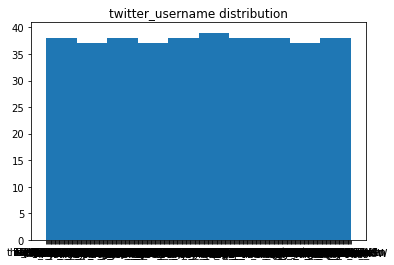

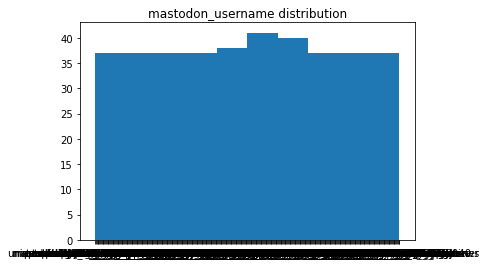

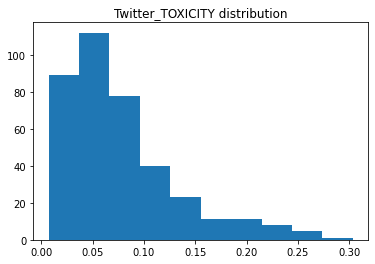

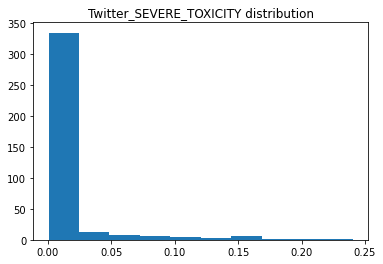

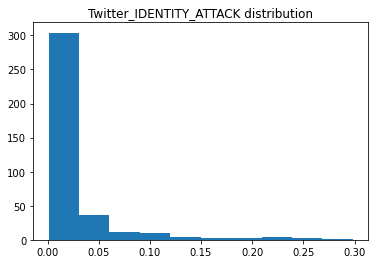

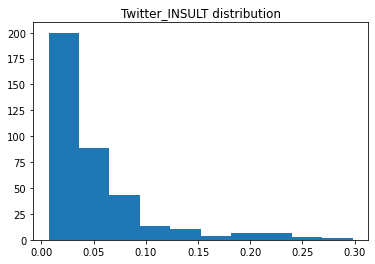

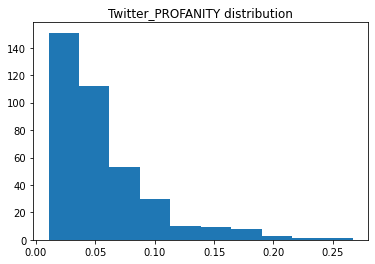

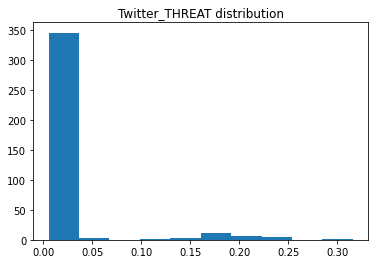

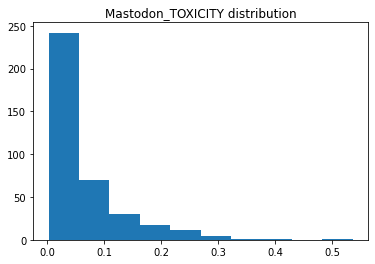

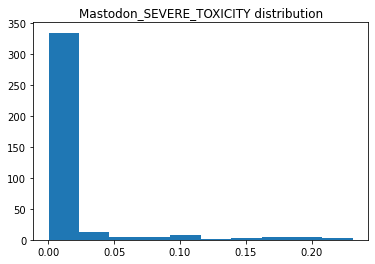

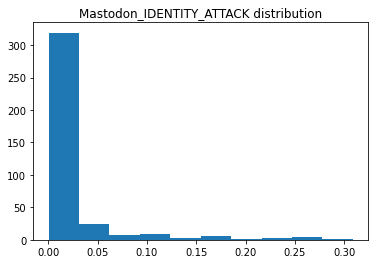

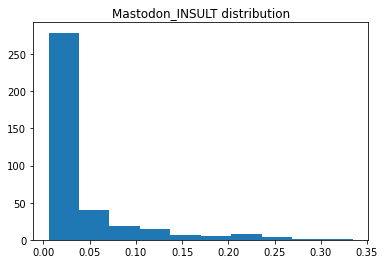

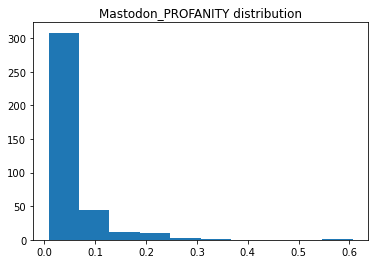

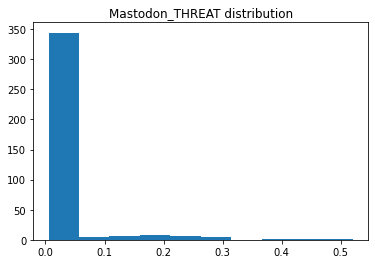

In [32]:
for col in scores.columns :
    plt.figure()
    plt.title(f'{col} distribution')
    plt.hist(scores[col])

In [33]:
scores['Twitter_TOXICITY'].corr(scores['Mastodon_TOXICITY'])

0.5901796276356103

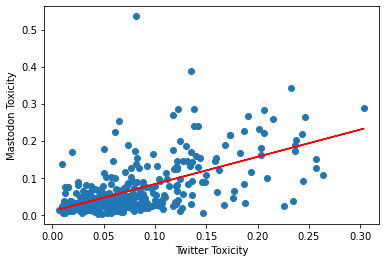

In [38]:
plt.scatter(x= scores['Twitter_TOXICITY'], y= scores['Mastodon_TOXICITY'])
plt.xlabel('Twitter Toxicity')
plt.ylabel('Mastodon Toxicity')
m, b = np.polyfit(scores['Twitter_TOXICITY'], scores['Mastodon_TOXICITY'], 1)

#add linear regression line to scatterplot 
plt.plot(scores['Twitter_TOXICITY'], m*scores['Twitter_TOXICITY']+b,color='red')